In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization
from keras.optimizers import Adam

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


# 1. Import the data

In [2]:
train = pd.read_csv("/kaggle/input/facial-keypoints-detection/training.zip")

# 2. Preprocessing the data

As we see here we have null values in most of our columns so we need to preprocess that somehow

In [ ]:
print(train.isnull().sum())

We tried imputation last time, but it wouldn't be a good approach since the mean values can be far from the actuall image positions they should be at which would give us bad results.<br>
Maybe it's best we drop the rows with null values which will give us less data but will probably improve our precision.

In [3]:
train = train.dropna()

We will separate the features from the labels first.

In [4]:
x = train['Image']
Y = train.drop(['Image'], axis=1)

Then we need to split the train data from the validation data so we don't have data leakage.

In [5]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_Y, val_Y = train_test_split(x, Y, test_size=0.2)

We're gonna pack our pictures into an array of arrays which are all size 96x96, because the pictures are of that resolution.

In [6]:
reshaped_train_x = []
reshaped_val_x = []

for entry in train_x:
    reshaped_entry = list(map(int, entry.split()))
    reshaped_entry = np.array(reshaped_entry).reshape(96, 96, 1)
    reshaped_train_x.append(reshaped_entry)
    
for entry in val_x:
    reshaped_entry = list(map(int, entry.split()))
    reshaped_entry = np.array(reshaped_entry).reshape(96, 96, 1)
    reshaped_val_x.append(reshaped_entry)

In [7]:
reshaped_train_x = tf.convert_to_tensor(reshaped_train_x, np.float32)
reshaped_val_x = tf.convert_to_tensor(reshaped_val_x, np.float32)

Normalization of Y

In [8]:
train_Y /= 96
val_Y /= 96

# 3. Defining the model

In [23]:
model = Sequential()

model.add(Lambda(lambda x: x/255.0, input_shape=(96, 96, 1)))
model.add(Conv2D(64, 7, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 7, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.5))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(96, activation='relu'))
model.add(Dense(30, activation='relu'))

optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 96, 96, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        3200      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 39, 39, 64)        200768    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 19, 19, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 15, 15, 32)       

In [25]:
history = model.fit(
    x=reshaped_train_x,
    y=train_Y,
    batch_size=128,
    epochs=30,
    validation_data=(reshaped_val_x, val_Y)
)

Epoch 1/30
14/14 [==============================] - 65s 4s/step - loss: 0.1587 - accuracy: 0.1700 - val_loss: 0.2234 - val_accuracy: 0.2056
Epoch 2/30
14/14 [==============================] - 63s 4s/step - loss: 0.0628 - accuracy: 0.1992 - val_loss: 0.1358 - val_accuracy: 0.7266
Epoch 3/30
14/14 [==============================] - 63s 4s/step - loss: 0.0355 - accuracy: 0.2926 - val_loss: 0.0578 - val_accuracy: 0.2290
Epoch 4/30
14/14 [==============================] - 63s 4s/step - loss: 0.0141 - accuracy: 0.3154 - val_loss: 0.0140 - val_accuracy: 0.7266
Epoch 5/30
14/14 [==============================] - 62s 4s/step - loss: 0.0104 - accuracy: 0.4550 - val_loss: 0.0110 - val_accuracy: 0.7266
Epoch 6/30
14/14 [==============================] - 62s 4s/step - loss: 0.0091 - accuracy: 0.4953 - val_loss: 0.0092 - val_accuracy: 0.7266
Epoch 7/30
14/14 [==============================] - 62s 4s/step - loss: 0.0086 - accuracy: 0.4977 - val_loss: 0.0110 - val_accuracy: 0.7266
Epoch 8/30
14/14 [==

# 4. Results

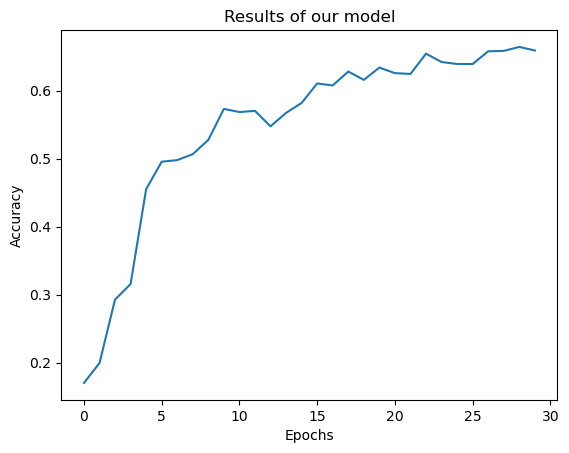

In [26]:
import matplotlib.pyplot as plt
plt.title("Results of our model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'])

Although I didn't think loss was merit for evaluating our model, I still ploted the values to see what was happening.<br>
It doesn't seem there is any form of overfitting even though we let the model run for 200 epochs.

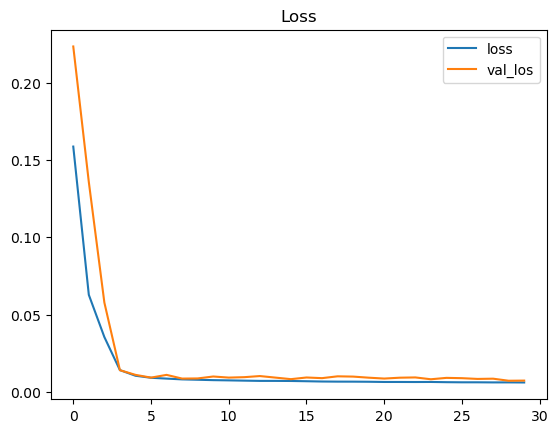

In [27]:
plt.title("Loss")
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_los")
plt.legend()
plt.show()

In [ ]:
keypoints

1/1 [==============================] - 0s 33ms/step


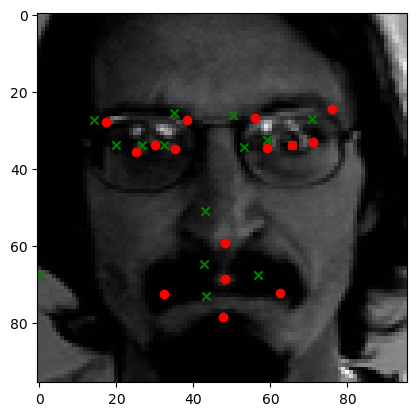

In [29]:
image_indx = 1
keypoints = model.predict(tf.reshape(reshaped_train_x[image_indx]/255.0, [1,96,96,1]))
x = []
y = []
actual_x = []
actual_y = []
for i in range(len(keypoints[0])):
    if i % 2 == 0:
        x.append(keypoints[0][i]*96)
        actual_x.append(train_Y.iloc[image_indx,i]*96)
    else:
        y.append(keypoints[0][i]*96)
        actual_y.append(train_Y.iloc[image_indx,i]*96)
plt.imshow(reshaped_train_x[image_indx], cmap='gray')
plt.scatter(x, y, marker='x',color='green')
plt.scatter(actual_x, actual_y, marker='o', color='red')
plt.show()